In [1]:
from IPython.display import Image, display

Linuxbrew (http://linuxbrew.sh/) - another package manager It can be useful in future if you ever run into tools that aren't on APT.

dpkg -L {package-name} - показывает путь к файлу (исполняемые файлы лежат в /usr/bin directory)

# 10.29.20 День 1

21:58 засел за чтение материалов

# 1. Знакомство

### Файлы:

"This is E.coli strain K-12 substrain MG1655, laboratory workhorse. More information about this genome can be found at 
http://www.ncbi.nlm.nih.gov/genome/167"


GCF_000005845.2_ASM584v2_genomic.fna.gz - reference sequence in fasta format

GCF_000005845.2_ASM584v2_genomic.gff.gz - annotation

---
---
need raw Illumina sequencing reads from shotgun sequencing of an E. coli strain that is resistant to the antibiotic ampicillin:

amp_res_1.fastq.zip - forward

amp_res_2.fastq.zip - reverse

---

Распаковка архивов

```bash
in: 
unzip amp_res_1.fastq.zip

out: 
Archive:  amp_res_1.fastq.zip
  inflating: amp_res_1.fastq  ```

Ручной просмотр сырых данных

```bash
in: 
head -4 amp_res_2.fastq

out: 
@SRR1363257.37 GWZHISEQ01:153:C1W31ACXX:5:1101:14027:2198 length=101
GATCTAAGCTGAAGCCAGGCCAAAGTTTGACGATTGGTGCAGGCAGTAGCGCACAGCGACTGGCAAACAACAGCGATAGCATTACGTATCGTGTGCGCAAA
+
???BDB:DFHBFD@9;;+A;AFGH;ABHFHHGE@9:B:??@D>@;F?D8<<F8AA9EHHD8'..;5?A?A992(',(59CC3@C>22::A238+2>B<>B<
```

Ручной просмотр референсного генома:

```bash
cat GCF_000005845.2_ASM584v2_genomic.fna

out: 
a huuuge genetic string
```

Число строк в файлах прямого и обратного прочтения:

```bash
in:
wc -l amp_res_1.fastq

out:
1823504 amp_res_1.fastq

in:
wc -l amp_res_2.fastq

out:
1823504 amp_res_2.fastq
```

# 2. FastQC

Анализ сырых файлов с помощью __fastqc__ (установка - sudo apt-get install fastqc)
```bash
in:
fastqc -o . amp_res_1.fastq amp_res_2.fastq

out:
Started analysis of amp_res_1.fastq
Approx 5% complete for amp_res_1.fastq
.
.
Analysis complete for amp_res_1.fastq
Started analysis of amp_res_2.fastq
Approx 5% complete for amp_res_2.fastq
.
.
Analysis complete for amp_res_2.fastq
```

`-o .` говорит "положи аутпут в текущую директеорию" (в ней появились файлы `amp_res_1_fastqc.html` и `amp_res_1_fastqc.html`)

### значение Total_sequences не совпадает со значением, полученным с помощью wc -l:
455876 против 1823504

### Fastqc Failures (красные кружочки):
#### В файле 1:
1. Per base sequence quality
2. Per tile sequence quality

#### В файле 2:
1. Per base sequence quality

http://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/ гласит:

1. "Наиболее часто встречающееся среднее качество" меньше 20. Это соответствует ошибке в 1% (предположительно по систематическим причинам)
2. Нижний квартиль (10%) хотя бы для 1 из оснований ниже 5, либо медиана ниже 20.

Что предпринять:
- провести тех.осмотр и калибровку секвенатора?
- возможно были нарушения технологии в процессе секвенирования?


Есть ещё Warning-и (но когда всё было хорошо):
1. Per tile sequence quality
2. Per base sequence content
3. Per sequence GC content

# 3. Trimmomatic
www.usadellab.org/cms/?page=trimmomatic
- TrimmomaticPE - paired end mode
- TrimmomaticSE - single end mode

# 30.10.20 День 2 
23:02

encoding: Phred+33 

```bash
in:
TrimmomaticPE -phred33 -trimlog ogloglock.txt -summary -summary.txt amp_res_1.fastq amp_res_2.fastq _1P.fq _1U.fq _2P.fq _2U.fq  LEADING:20 TRAILING:20 SLIDINGWINDOW:10:20 MINLEN:20

out:
TrimmomaticPE: Started with arguments:
 -phred33 -trimlog ogloglock.txt -summary -summary.txt amp_res_1.fastq amp_res_2.fastq _1P.fq _1U.fq _2P.fq _2U.fq LEADING:20 TRAILING:20 SLIDINGWINDOW:10:20 MINLEN:20
Multiple cores found: Using 4 threads

Input Read Pairs: 455876 Both Surviving: 446259 (97.89%) Forward Only Surviving: 9216 (2.02%) Reverse Only Surviving: 273 (0.06%) Dropped: 128 (0.03%)
TrimmomaticPE: Completed successfully

```
### Проверка количества оставшихся ридов

```bash
in:
wc -l _P1.fq

out:
1785036
Для Р2 то же
```

### ФастКуСи на обрезанных файлах
в \_1P_fastqc только один красный кружок. В \_Р2 красных кружков нет!

С повышением мин.куолити соответственно просле триммирования остаётся меньше строк, и повышается среднее качество

# BWA

```bash
in:
bwa index -p pref GCF_000005845.2_ASM584v2_genomic.fna

...

in: bwa mem GCF_000005845.2_ASM584v2_genomic.fna _1P.fq _2P.fq > alignment.sam

```
https://samtools.github.io/hts-specs/SAMv1.pdf

"The sam file contains all reads, whether they successfully aligned or not. For bioinformatics pipelines, it’s important to know what fraction of your reads aligned."


 
```bash
in:
samtools view -S -b alignment.sam > alignment.bam  # Compressing .sam files

in:
samtools flagstat alignment.bam  # basic statistics
out:

892776 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
258 + 0 supplementary
0 + 0 duplicates
891649 + 0 mapped (99.87% : N/A)
892518 + 0 paired in sequencing
446259 + 0 read1
446259 + 0 read2
888554 + 0 properly paired (99.56% : N/A)
890412 + 0 with itself and mate mapped
979 + 0 singletons (0.11% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)

```

99.87% reads mapped

индексирование бам-файла:
```bash
in:
samtools sort alignment.bam -o alignment_sorted.bam   #  отсортировать по sequence coordinate on reference

in:
samtools index alignment_sorted.bam  # собсна индексирование
```

Визуализация с igv не пошла. Что-то там про отсутствие хромосом. Let's call it a day.

# День 3,  31.10.20, 20:13

...а теперь пошла. Вспоминая события той ужасной ночи: предположительно в первый раз я загрузил какой-то левый файл, а следующие попытки всё на самом деле работало - надо было приблизить, чтобы в этом убедиться.

In [3]:
display(Image(url='https://sun9-29.userapi.com/CQNZ1jBzKVHvaLqMzm1WgZ9kK9UfNSR6tr1zQw/mC1iBmwGA9I.jpg'))
display(Image(url='https://sun9-29.userapi.com/3tS51AcIcb7_61867dm9Q4yX0Pi0WcRpz8JnIQ/RPUcqHPjB3Y.jpg'))

Словно вся жизнь кишечной палочки проносится у меня перед глазами

## mpileup и все-все-все

mpileup проходит по всем позициям и смотрит на число совпадающих и несовпадающих нуклеотидов (относительно референса)

```bash
in:
samtools mpileup -f GCF_000005845.2_ASM584v2_genomic.fna alignment_sorted.bam > my.mpileup

out:
[mpileup] 1 samples in 1 input files
```
VCR-файлы:
```bash
java -jar VarScan.v2.3.9.jar  mpileup2snp my.mpileup --min-var-freq 0.9 --variants --output-vcf 1 > VarScan_results.vcf
java -jar VarScan.v2.3.9.jar  mpileup2snp my.mpileup --min-var-freq 0.5 --variants --output-vcf 1 > VarScan_results50.vcf
```
Результаты с минимальными частотами 0.5 и 0.9 совпадают:

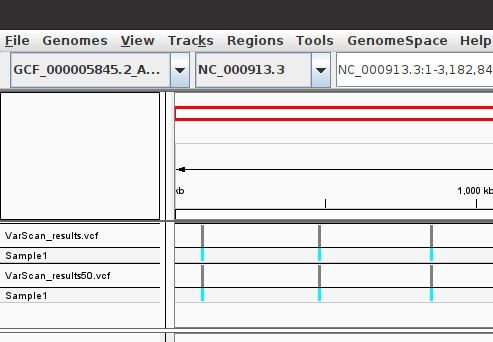

In [4]:
Image('https://sun9-47.userapi.com/K8IDpFFPuPnbIuIF1mz-YcK8i55gkf9TA7bdbQ/_zjj8qTxUNY.jpg')

In [5]:
import pandas as pd

In [10]:
df = pd.read_csv('VARIANTS.txt', sep='\t')


,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,Sample1
0,NC_000913.3,93043,.,C,G,.,PASS,ADP=17;WT=0;HET=0;HOM=1;NC=0,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:93:18:17:0:17:100%:4.2852E-10:0:36:0:0:6:11
1,NC_000913.3,482698,.,T,A,.,PASS,ADP=16;WT=0;HET=0;HOM=1;NC=0,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:87:16:16:0:16:100%:1.6637E-9:0:45:0:0:12:4
2,NC_000913.3,852762,.,A,G,.,PASS,ADP=14;WT=0;HET=0;HOM=1;NC=0,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:76:14:14:0:14:100%:2.4927E-8:0:36:0:0:9:5
3,NC_000913.3,3535147,.,A,C,.,PASS,ADP=17;WT=0;HET=0;HOM=1;NC=0,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:93:17:17:0:17:100%:4.2852E-10:0:36:0:0:12:5
4,NC_000913.3,4390754,.,G,T,.,PASS,ADP=15;WT=0;HET=0;HOM=1;NC=0,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:81:16:15:0:15:100%:6.4467E-9:0:36:0:0:8:7
